In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.signal as sg

from gravity_toolkit.harmonics import harmonics
from gravity_toolkit.grace_find_months import grace_find_months
from gravity_toolkit.grace_input_months import grace_input_months
from gravity_toolkit.spatial import spatial

from gravity_toolkit.toolbox import create_grid, grid_to_hs, filt_Ylms

# maximal degree to load for the Stokes coefficients
n_harmo = 3

# Base directory with all the dataset (see read-GRACE-harmonics installation)
base_dir = '/home/hugo/Documents/GRACE_DATA'

In [2]:
# Read CSR, GRAZ and COST-G data from the GRACE mission from the april 2002 to end of 2022

total_months = grace_find_months(base_dir, 'CSR', 'RL06', DSET='GSM')
start_mon = np.min(total_months['months'])
end_mon = 251 # end of 2022
settmp = set(np.arange(start_mon,end_mon+1)) - set(total_months['months'])
missing = sorted(settmp)
Ylms = grace_input_months(base_dir, 'CSR', 'RL06', 'GSM',
    n_harmo, start_mon, end_mon, missing, SLR_C20='GSFC', DEG1='', SLR_C30='GSFC')
# create harmonics object and remove mean
GRACE_Ylms = harmonics().from_dict(Ylms)

total_months = grace_find_months(base_dir, 'GRAZ', 'RL18', DSET='GSM')
settmp = set(np.arange(start_mon,end_mon+1)) - set(total_months['months'])
missing = sorted(settmp)
Ylms = grace_input_months(base_dir, 'GRAZ', 'RL18', 'GSM',
    n_harmo, start_mon, end_mon, missing, SLR_C20='GSFC', DEG1='', SLR_C30='GSFC')
# create harmonics object and remove mean
GRAZ_Ylms = harmonics().from_dict(Ylms)

total_months = grace_find_months(base_dir, 'COSTG', 'RL06', DSET='GSM')
settmp = set(np.arange(start_mon,end_mon+1)) - set(total_months['months'])
missing = sorted(settmp)
Ylms = grace_input_months(base_dir, 'COSTG', 'RL06', 'GSM',
    n_harmo, start_mon, end_mon, missing, SLR_C20='GSFC', DEG1='', SLR_C30='GSFC')
# create harmonics object and remove mean
COSTG_Ylms = harmonics().from_dict(Ylms)

# remove mean to talk in gravity anomalies
GRACE_Ylms.mean(apply=True)
GRAZ_Ylms.mean(apply=True)
COSTG_Ylms.mean(apply=True)

# Temporal filtering with a 3 year low pass filter
GRACE_filt_Ylms = filt_Ylms(GRACE_Ylms.copy(), filt='fft', filt_param=[1/3])
GRAZ_filt_Ylms = filt_Ylms(GRAZ_Ylms.copy(), filt='fft', filt_param=[1/3])
COSTG_filt_Ylms = filt_Ylms(COSTG_Ylms.copy(), filt='fft', filt_param=[1/3])

In [3]:
# remove trend to remove GIA effects and have a better spectral analysis
detrend=True

# list of IGG-SLR file
files = os.listdir(os.path.join(base_dir, 'IGG/IGG_SLR_HYBRID'))
files.sort()

# create a harmonics object to fill with IGG-SLR data
ylms_slr = harmonics(lmax=n_harmo, mmax=n_harmo)
ylms_slr.time = np.zeros(len(files))
ylms_slr.month = np.zeros(len(files))
ylms_slr.clm = np.zeros((n_harmo+1, n_harmo+1, len(files)))
ylms_slr.slm = np.zeros((n_harmo+1, n_harmo+1, len(files)))

ylms_slr.update_dimensions()

# fill the harmonics object
for i, f in enumerate(files):
    ylms_tmp = harmonics().from_gfc(os.path.join(base_dir, 'IGG/IGG_SLR_HYBRID', f))
    ylms_slr.time[i] = int(f[23:27]) + int(f[28:30])/12 - 1/24
    ylms_slr.clm[:,:, i] = ylms_tmp.clm[:n_harmo+1, :n_harmo+1]
    ylms_slr.slm[:,:, i] = ylms_tmp.slm[:n_harmo+1, :n_harmo+1]

# convert decimal year to GRACE month equivalent
ylms_slr.month = np.floor((ylms_slr.time - 2002)*12)
# remove mean to talk in gravity anomalies
ylms_slr.mean(apply=True)


# Read ISBA data in m EWH after index 170 (= start of IGG-SLR product)
grid_isba_slr = spatial().from_HDF5(os.path.join(base_dir, 'HYDRO/ISBA-CTRIP_erai_gpcc_monthly_tws_1979-2019.nc'), date=True, timename='time_counter', lonname='lon', latname='lat', varname='tws')
grid_isba_slr.data[grid_isba_slr.mask] = 0 # Set masked data to 0
# swap axes to get (lon, lat, time)
grid_isba_slr.data = np.swapaxes(grid_isba_slr.data[170:, :, :], 0,2)/1000 #divide by rho_water
grid_isba_slr.data = np.swapaxes(grid_isba_slr.data, 0,1)*100 #go to cm EWH
grid_isba_slr.mask = np.swapaxes(grid_isba_slr.mask[170:, :, :], 0,2)
grid_isba_slr.mask = np.swapaxes(grid_isba_slr.mask, 0,1)

# concert time from day to decimal year
grid_isba_slr.time = 1979 + grid_isba_slr.time[170:]/365.25
# convert decimal year to GRACE month equivalent
grid_isba_slr.month = np.floor((grid_isba_slr.time - 2002)*12)

# remove mean to talk in gravity anomalies
grid_isba_slr.mean(apply=True)

# from grid to harmonics
isba_Ylms_long = grid_to_hs(grid_isba_slr, n_harmo)

# remove trend to remove GIA effects and have a better spectral analysis
if detrend:
    isba_Ylms_long.slm[2,2] = sg.detrend(isba_Ylms_long.slm[2,2])
    ylms_slr.slm[2,2] = sg.detrend(ylms_slr.slm[2,2])

# Temporal filtering with a 3 year low pass filter    
isba_filt_Ylms_long = filt_Ylms(isba_Ylms_long.copy(), filt='fft', filt_param=[1/3])
SLR_filt_Ylms = filt_Ylms(ylms_slr.copy(), filt='fft', filt_param=[1/3])

# create IGG-SLR - ISBA + temporal filtering
SLR_filt_isba_Ylms = filt_Ylms(ylms_slr.copy().subtract(isba_filt_Ylms_long), filt='fft', filt_param=[1/3])

Time length of IGG-SLR : 28.083333333333258  yr
Time length of IGG-SLR - ISBA : 25.75  yr


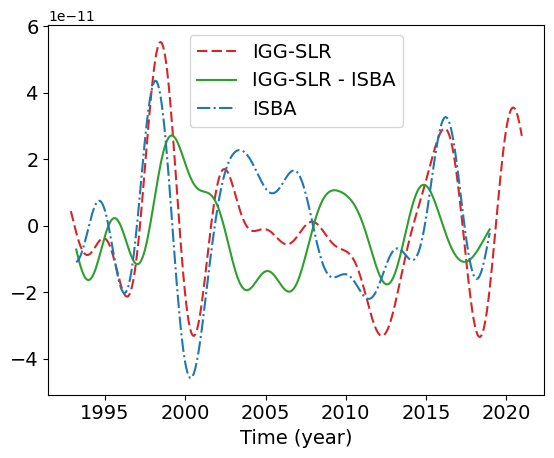

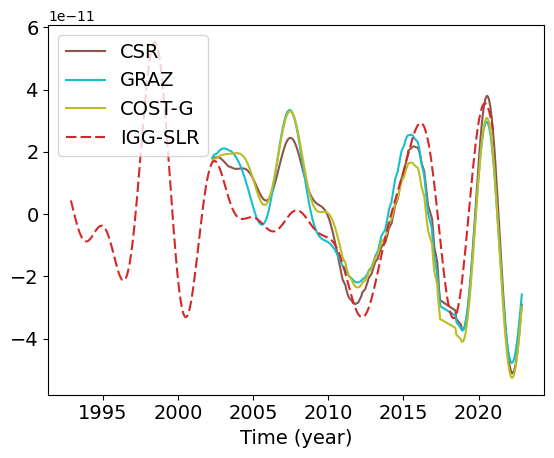

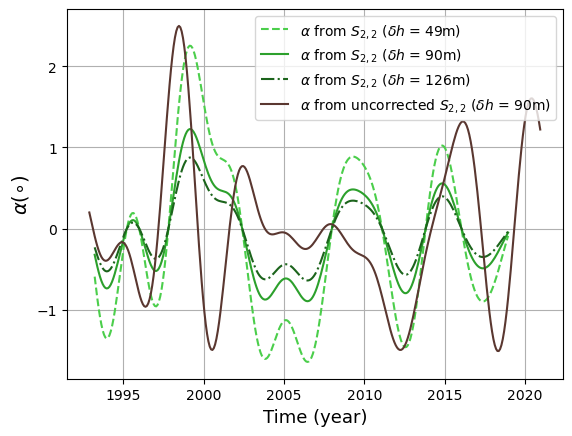

In [4]:
print("Time length of IGG-SLR :", SLR_filt_Ylms.time[-1] - SLR_filt_Ylms.time[0], " yr")
print("Time length of IGG-SLR - ISBA :", SLR_filt_isba_Ylms.time[-1] - SLR_filt_isba_Ylms.time[0], " yr")

# Figure 2a of the paper
plt.figure()
plt.plot(SLR_filt_Ylms.time, SLR_filt_Ylms.slm[2,2], label='IGG-SLR', color='C3', linestyle=(0, (5,2)))
plt.plot(SLR_filt_isba_Ylms.time, SLR_filt_isba_Ylms.slm[2,2], label='IGG-SLR - ISBA', color='C2')
plt.plot(isba_filt_Ylms_long.time, isba_filt_Ylms_long.slm[2,2], label='ISBA', color='C0', linestyle='dashdot')
plt.legend(fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Figure Supplementary Information S3a of the paper
plt.figure()
plt.plot(GRACE_filt_Ylms.time, GRACE_filt_Ylms.slm[2,2], label='CSR', color='C5')
plt.plot(GRAZ_filt_Ylms.time, GRAZ_filt_Ylms.slm[2,2], label='GRAZ', color='C9')
plt.plot(COSTG_filt_Ylms.time, COSTG_filt_Ylms.slm[2,2], label='COST-G', color='C8')
plt.plot(SLR_filt_Ylms.time, SLR_filt_Ylms.slm[2,2], label='IGG-SLR', color='C3', linestyle=(0, (5,2)))
plt.legend(fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Figure 3 of the paper
plt.figure()
# plot S22/(2*Kappa*delta h)*180/pi  (Equation 7b + conversion from radians to degree)
plt.plot(SLR_filt_isba_Ylms.time, SLR_filt_isba_Ylms.slm[2,2]/1.41e-11/49/np.pi*180, label=r'$\alpha$ from $S_{2,2}$ ($\delta h$ = 49m)', color='#4bce4b', linestyle='dashed')
plt.plot(SLR_filt_isba_Ylms.time, SLR_filt_isba_Ylms.slm[2,2]/1.41e-11/90/np.pi*180, label=r'$\alpha$ from $S_{2,2}$ ($\delta h$ = 90m)', color='C2')
plt.plot(SLR_filt_isba_Ylms.time, SLR_filt_isba_Ylms.slm[2,2]/1.41e-11/126/np.pi*180, label=r'$\alpha$ from $S_{2,2}$ ($\delta h$ = 126m)', color='#1c641c', linestyle='dashdot')
plt.plot(SLR_filt_Ylms.time, SLR_filt_Ylms.slm[2,2]/1.41e-11/90/np.pi*180, label=r'$\alpha$ from uncorrected $S_{2,2}$ ($\delta h$ = 90m)', color='#5a3730')

plt.grid()
plt.ylabel(r'$\alpha (\circ)$', fontsize=14)
plt.xlabel('Time (year)', fontsize=13)
plt.legend()
plt.show()

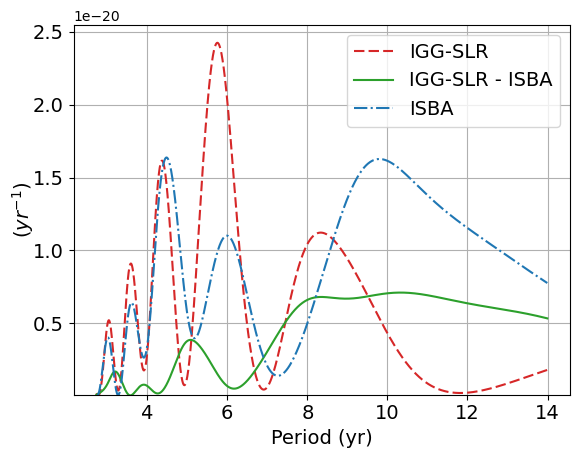

In [5]:
# Figure 2b of the paper
windows = 48

# windows creation to reduce the apodization effect
global_hann = sc.signal.windows.hamming(windows)[:windows//2]
slr_hann = np.concatenate((global_hann, np.ones(len(SLR_filt_Ylms.time)-windows), global_hann[::-1]))
slrisba_hann = np.concatenate((global_hann, np.ones(len(SLR_filt_isba_Ylms.time)-windows), global_hann[::-1]))

# compute periodogram
w = np.linspace(0.449, 2.3, 5000)[::-1]
pgram = sg.lombscargle(SLR_filt_Ylms.time.copy(), SLR_filt_Ylms.slm[2,2]*slr_hann, w.copy(), normalize=False)
pgram_slr_isba = sg.lombscargle(SLR_filt_isba_Ylms.time.copy(), SLR_filt_isba_Ylms.slm[2,2]*slrisba_hann, w.copy(), normalize=False)
pgram_isba = sg.lombscargle(isba_filt_Ylms_long.time.copy(), isba_filt_Ylms_long.slm[2,2]*slrisba_hann, w.copy(), normalize=False)

plt.figure()
plt.plot(2*np.pi/w, pgram, label='IGG-SLR', color='C3', linestyle=(0, (5,2)))
plt.plot(2*np.pi/w, pgram_slr_isba, label='IGG-SLR - ISBA', color='C2')
plt.plot(2*np.pi/w, pgram_isba, label='ISBA', color='C0', linestyle='dashdot')

plt.xlabel('Period (yr)', labelpad=4, fontsize=14)
plt.ylabel('($yr^{-1}$)', labelpad=-2, fontsize=14)
plt.ylim(10**-22)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

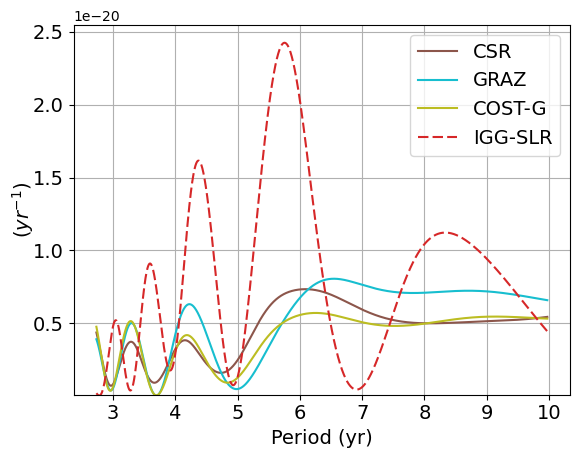

In [6]:
# Figure Supplementary Information S3b of the paper
windows = 48

# windows creation to reduce the apodization effect
global_hann = sc.signal.windows.hamming(windows)[:windows//2]
slr_hann = np.concatenate((global_hann, np.ones(len(SLR_filt_Ylms.time)-windows), global_hann[::-1]))
grace_hann = np.concatenate((global_hann, np.ones(len(GRACE_filt_Ylms.time)-windows), global_hann[::-1]))
graz_hann = np.concatenate((global_hann, np.ones(len(GRAZ_filt_Ylms.time)-windows), global_hann[::-1]))

# compute periodogram
w = np.linspace(0.63, 2.3, 5000)[::-1]
pgram = sg.lombscargle(SLR_filt_Ylms.time.copy(), SLR_filt_Ylms.slm[2,2]*slr_hann, w.copy(), normalize=False)
pgram_grace = sg.lombscargle(GRACE_filt_Ylms.time.copy(), GRACE_filt_Ylms.slm[2,2]*grace_hann, w.copy(), normalize=False)
pgram_graz = sg.lombscargle(GRAZ_filt_Ylms.time.copy(), GRAZ_filt_Ylms.slm[2,2]*graz_hann, w.copy(), normalize=False)
pgram_costg = sg.lombscargle(COSTG_filt_Ylms.time.copy(), COSTG_filt_Ylms.slm[2,2]*grace_hann, w.copy(), normalize=False)

plt.figure()
plt.plot(2*np.pi/w, pgram_grace, label='CSR', color='C5')
plt.plot(2*np.pi/w, pgram_graz, label='GRAZ', color='C9')
plt.plot(2*np.pi/w, pgram_costg, label='COST-G', color='C8')
plt.plot(2*np.pi/w, pgram, label='IGG-SLR', color='C3', linestyle=(0, (5,2)))

plt.xlabel('Period (yr)', labelpad=4, fontsize=14)
plt.ylabel('($yr^{-1}$)', labelpad=-2, fontsize=14)
plt.ylim(10**-22)
plt.legend(loc='upper right', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

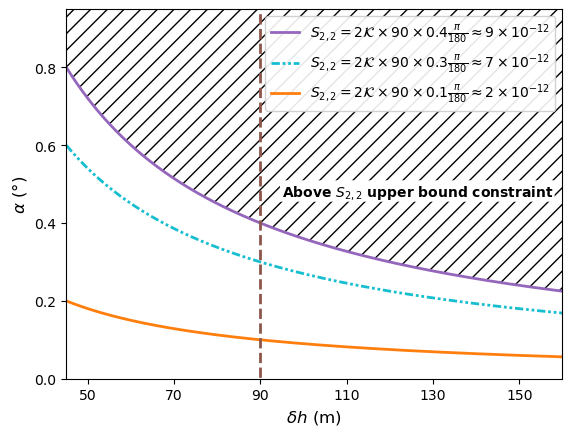

In [7]:
# Figure 4 of the paper

plt.figure()
# create alpha and delta h range
alpha = np.arange(0.08, 1.2, 0.005)
h = np.arange(45, 160, 0.01)
# rectangle for the inscription "Above $S_{2,2}$ ..."
h2 = np.arange(94.5, 158.2, 0.01) 

# three line for three alpha maximal value at delta h = 90m
plt.plot(h, 90*0.4/h, label=r'$S_{2,2} = 2 \mathcal{K} \times 90 \times {0.4} \frac{\pi}{180} \approx 9 \times 10^{-12}$', lw=2, color='C4')
plt.plot(h, 90*0.3/h, label=r'$S_{2,2} = 2 \mathcal{K} \times 90 \times {0.3} \frac{\pi}{180} \approx 7 \times 10^{-12}$', lw=2, color='C9', linestyle=(0,(3,1,1,1,1,1)))
plt.plot(h, 90*0.1/h, label=r'$S_{2,2} = 2 \mathcal{K} \times 90 \times {0.1} \frac{\pi}{180} \approx 2 \times 10^{-12}$', lw=2, color='C1')

# hatch couple values of alpha, delta h that cannot be reach
plt.fill_between(h, 90*0.4/h, 2*np.ones(h.shape), hatch='//', fc='w', alpha=0.8)

# dashed line for delta h = 90m
plt.plot([90,90], [1.2,0], '--', lw=2, color='C5')
# rectangle for the inscription "Above $S_{2,2}$ ..."
plt.fill_between(h2, 0.455*np.ones(h2.shape), 0.51*np.ones(h2.shape), fc='w') 
plt.text(95, 0.47, 'Above $S_{2,2}$ upper bound constraint', weight="bold")

plt.xlabel('$\delta h$ (m)', fontsize=12)
plt.ylabel(r'$\alpha~(°)$', fontsize=12)
plt.xticks([50, 70, 90, 110, 130, 150])
plt.xlim(45, 160)
plt.ylim(0, 0.95)
plt.legend(framealpha=0.9)
plt.show()

In [8]:
# calculation of maximal value for alpha based on LOD change with an amplitude ms and a period y
ms = 1e-3
y = 20

# equation 8
print("Low Γ value :", 360/86400**2*7.129e37/3e19*ms/(y*31536000))
print("Large Γ value :", 360/86400**2*7.129e37/2e20*ms/(y*31536000))

Low Γ value : 0.18169617014874107
Large Γ value : 0.027254425522311162


For a period of 30 yr, spectral resolution on C04 time series is between :  18.75 and  75.0
For a period of 30 yr, spectral resolution on C01 time series is between :  21.428571428571427 and  50.00000000000001


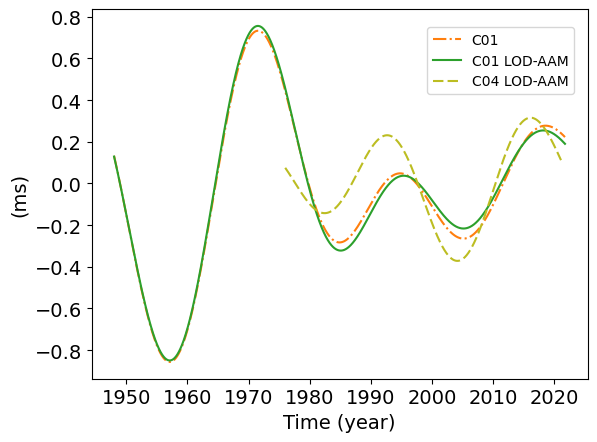

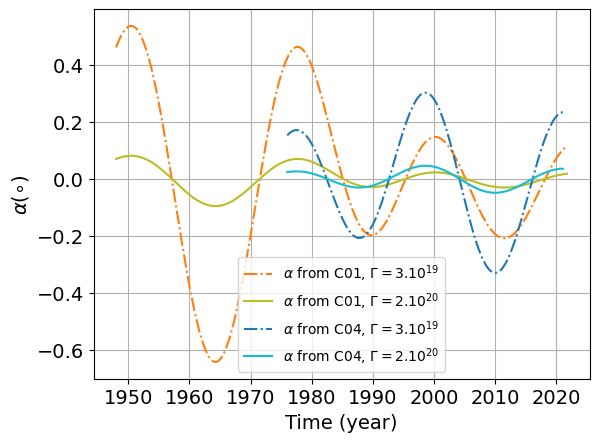

In [9]:
# Figure Supplementary Information S1a and S2a
p = 30 #period of 30 years

l = 50 #length of the LOD time series for C04
pmin = p - np.abs(p - 1/(1/p + 1/l))
pmax = p + np.abs(p - 1/(1/p - 1/l))
print("For a period of 30 yr, spectral resolution on C04 time series is between : ", pmin, "and ", pmax)
fmin, fmax = 1/pmax, 1/pmin

# read C04 file
f = open(os.path.join(base_dir, "LOD/lod_AOHSl.txt"), 'r')
lines = f.readlines()

# create a new LOD to remove trend and AAM, OAM, HAM, ...
lod = np.zeros((len(lines) - 7, 7))
for i, l in enumerate(lines[7:]):
    lod[i, :-1] = np.array(l.split())
   
lod[:,6] = lod[:,1] - lod[:,2]

for i in range(1,7):
    lod[:,i] = sg.detrend(lod[:,i])
    
# temporally filter LOD
filt_lod = lod.copy()

ndata = lod.shape[0]
# compute the mean time delta of the object
dt = float(np.mean((lod[1:, 0] - lod[:-1, 0])))

# fft filtering with 2**n2 zero padding
for i in range(1,7):
    s = lod[:,i].copy()

    # zero pad
    n2 = 0
    while ndata > 2 ** n2:
        n2 += 1
    n2 += 1

    f = np.fft.fft(s, n=2 ** n2)
    freq = np.fft.fftfreq(2 ** n2, d=dt)
    to_zero = np.logical_or(freq > fmax, freq < -fmax) | np.logical_and(freq < fmin, freq > -fmin)
    f[to_zero] = 0
    filt_lod[:,i] = np.real(np.fft.ifft(f))[:ndata]


l = 75 #length of the LOD time series for C01
pmin = p - np.abs(p - 1/(1/p + 1/l))
pmax = p + np.abs(p - 1/(1/p - 1/l))
print("For a period of 30 yr, spectral resolution on C01 time series is between : ", pmin, "and ", pmax)
fmin, fmax = 1/pmax, 1/pmin

# read C01
f = open(os.path.join(base_dir, "LOD/lod_AAMncep1948-2023.dat"), 'r')
lines = f.readlines()

# create a new LOD to remove trend and AAM, OAM, HAM, ...
lod2 = np.zeros((len(lines) - 1, 4))
for i, l in enumerate(lines[1:]):
    lod2[i, :-1] = np.array(l.split())
   
lod2[:,3] = lod2[:,1] - lod2[:,2]

for i in range(1,4):
    lod2[:,i] = sg.detrend(lod2[:,i])
    
# temporally filter LOD
filt_lod2 = lod2.copy()

ndata = lod2.shape[0]
# compute the mean time delta of the object
dt = float(np.mean((lod2[1:, 0] - lod2[:-1, 0])))

# fft filtering with 2**n2 zero padding
for i in range(1,4):
    s = lod2[:,i].copy()

    # zero pad
    n2 = 0
    while ndata > 2 ** n2:
        n2 += 1
    n2 += 1

    f = np.fft.fft(s, n=2 ** n2)
    freq = np.fft.fftfreq(2 ** n2, d=dt)
    to_zero = np.logical_or(freq > fmax, freq < -fmax) | np.logical_and(freq < fmin, freq > -fmin)
    f[to_zero] = 0
    filt_lod2[:,i] = np.real(np.fft.ifft(f))[:ndata]
    
plt.figure()
plt.plot(lod2[:,0], filt_lod2[:,1], label='C01', color='C1', linestyle='dashdot')
plt.plot(lod2[:,0], filt_lod2[:,3], label='C01 LOD-AAM', color='C2')
#plt.plot(lod[:,0], filt_lod[:,1], label='C04 LOD', color='C6')
plt.plot(lod[:,0], filt_lod[:,6], label='C04 LOD-AAM', color='C8', linestyle=(0, (5,2)))

plt.title('')
plt.ylabel('(ms)', fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=(0.6769, 0.77))

dlod = (filt_lod[1:,6] - filt_lod[:-1,6]) / ((lod[1:,0] - lod[:-1,0])*31536000)/1e3
dlod2 = (filt_lod2[1:,3] - filt_lod2[:-1,3]) / ((lod2[1:,0] - lod2[:-1,0])*31536000)/1e3

plt.figure()
plt.plot(lod2[:-1,0], -360/86400**2*7.129e37/3e19*dlod2, label=r'$\alpha$ from C01, $\Gamma=3.10^{19}$', color='C1', linestyle='dashdot')
plt.plot(lod2[:-1,0], -360/86400**2*7.129e37/2e20*dlod2, label=r'$\alpha$ from C01, $\Gamma=2.10^{20}$', color='C8')
plt.plot(lod[:-1,0], -360/86400**2*7.129e37/3e19*dlod, label=r'$\alpha$ from C04, $\Gamma=3.10^{19}$', color='C0', linestyle='dashdot')
plt.plot(lod[:-1,0], -360/86400**2*7.129e37/2e20*dlod, label=r'$\alpha$ from C04, $\Gamma=2.10^{20}$', color='C9')

plt.ylabel(r'$\alpha (\circ)$', fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend()
plt.show()

For a period of 30 yr, spectral resolution on C04 time series is between :  5.357142857142858 and  6.818181818181818
0.27328662391793657
0.07190718419811173
For a period of 30 yr, spectral resolution on C01 time series is between :  5.555555555555555 and  6.521739130434783


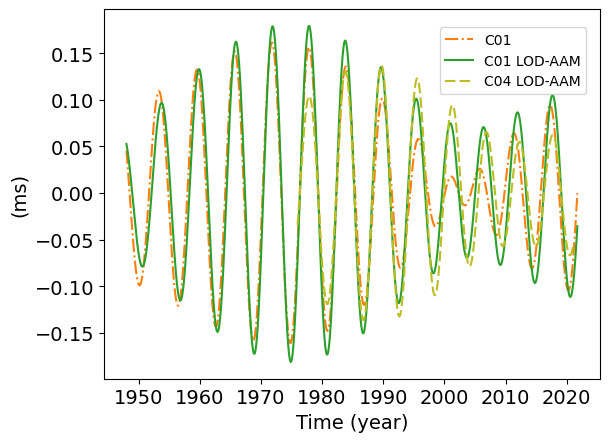

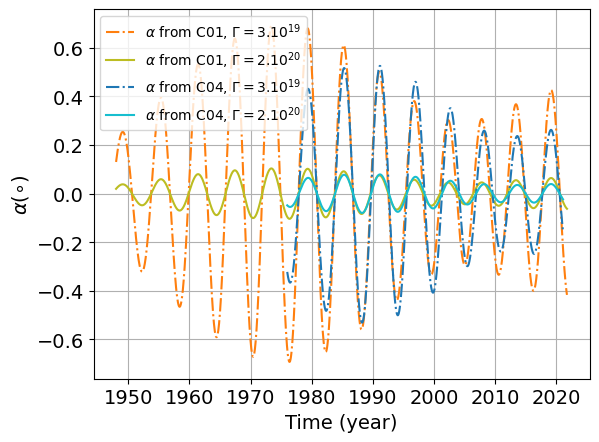

In [11]:
# Figure Supplementary Information S1b and S2b
p = 6 #period of 6 years
l = 50

pmin = p - np.abs(p - 1/(1/p + 1/l))
pmax = p + np.abs(p - 1/(1/p - 1/l))
print("For a period of 30 yr, spectral resolution on C04 time series is between : ", pmin, "and ", pmax)
fmin, fmax = 1/pmax, 1/pmin

filt_lod = lod.copy()

ndata = lod.shape[0]
# compute the mean time delta of the object
dt = float(np.mean((lod[1:, 0] - lod[:-1, 0])))

for i in range(1,7):
    s = lod[:,i].copy()

    # zero pad
    n2 = 0
    while ndata > 2 ** n2:
        n2 += 1
    n2 += 1

    f = np.fft.fft(s, n=2 ** n2)
    freq = np.fft.fftfreq(2 ** n2, d=dt)
    to_zero = np.logical_or(freq > fmax, freq < -fmax) | np.logical_and(freq < fmin, freq > -fmin)
    f[to_zero] = 0
    filt_lod[:,i] = np.real(np.fft.ifft(f))[:ndata]

print(np.max(filt_lod[:,6]) - np.min(filt_lod[:,6]))
print(np.std(filt_lod[:,6]))

l = 75 #length of the LOD time series for C01
pmin = p - np.abs(p - 1/(1/p + 1/l))
pmax = p + np.abs(p - 1/(1/p - 1/l))
print("For a period of 30 yr, spectral resolution on C01 time series is between : ", pmin, "and ", pmax)
fmin, fmax = 1/pmax, 1/pmin

filt_lod2 = lod2.copy()

ndata = lod2.shape[0]
# compute the mean time delta of the object
dt = float(np.mean((lod2[1:, 0] - lod2[:-1, 0])))

for i in range(1,4):
    s = lod2[:,i].copy()

    # zero pad
    n2 = 0
    while ndata > 2 ** n2:
        n2 += 1
    n2 += 1

    f = np.fft.fft(s, n=2 ** n2)
    freq = np.fft.fftfreq(2 ** n2, d=dt)
    to_zero = np.logical_or(freq > fmax, freq < -fmax) | np.logical_and(freq < fmin, freq > -fmin)
    f[to_zero] = 0
    filt_lod2[:,i] = np.real(np.fft.ifft(f))[:ndata]

plt.figure()
plt.plot(lod2[:,0], filt_lod2[:,1], label='C01', color='C1', linestyle='dashdot')
plt.plot(lod2[:,0], filt_lod2[:,3], label='C01 LOD-AAM', color='C2')
#plt.plot(lod[:,0], filt_lod[:,1], label='C04 LOD', color='C6')
plt.plot(lod[:,0], filt_lod[:,6], label='C04 LOD-AAM', color='C8', linestyle=(0, (5,2)))

plt.title('')
plt.ylabel('(ms)', fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=(0.6769, 0.77))

dlod = (filt_lod[1:,6] - filt_lod[:-1,6]) / ((lod[1:,0] - lod[:-1,0])*31536000)/1e3
dlod2 = (filt_lod2[1:,3] - filt_lod2[:-1,3]) / ((lod2[1:,0] - lod2[:-1,0])*31536000)/1e3

plt.figure()
plt.plot(lod2[:-1,0], -360/86400**2*7.129e37/3e19*dlod2, label=r'$\alpha$ from C01, $\Gamma=3.10^{19}$', color='C1', linestyle='dashdot')
plt.plot(lod2[:-1,0], -360/86400**2*7.129e37/2e20*dlod2, label=r'$\alpha$ from C01, $\Gamma=2.10^{20}$', color='C8')
plt.plot(lod[:-1,0], -360/86400**2*7.129e37/3e19*dlod, label=r'$\alpha$ from C04, $\Gamma=3.10^{19}$', color='C0', linestyle='dashdot')
plt.plot(lod[:-1,0], -360/86400**2*7.129e37/2e20*dlod, label=r'$\alpha$ from C04, $\Gamma=2.10^{20}$', color='C9')

plt.ylabel(r'$\alpha (\circ)$', fontsize=14)
plt.xlabel('Time (year)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend()
plt.show()